In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.io as sio
import copy
import pylab as pl
import time as tlib
from IPython import display
import matplotlib.gridspec as gridspec

#### Finding much accurately frequency by using Fourier Transforms even the frequency resolution is not high enough

#### The way do do it is.
1 Find the local high frequency.  
2 Get its phase  
**LHF** local high frequency  
**PH** phase  
**RU** resolution unit  
**Frequency = LHF + PH * RU / $\Pi$**

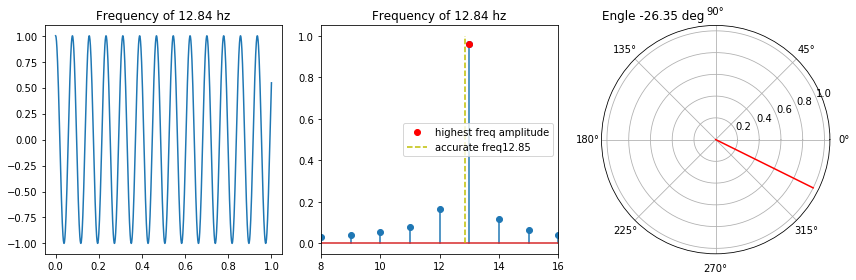

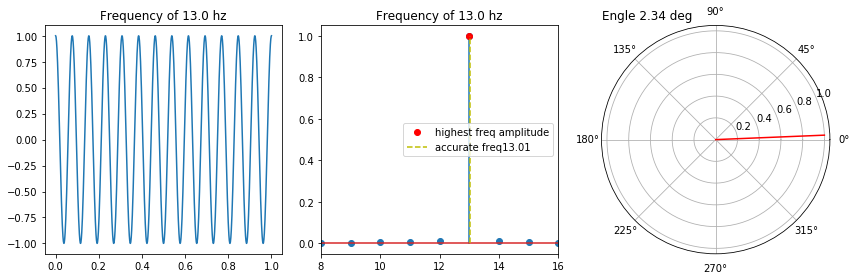

In [2]:
npnts = 1000
time = np.linspace(0, 1, npnts)

freqlen = 20
freqs = np.linspace(10, 13 , freqlen)
signals = np.zeros((freqlen, npnts))
for i in range(freqlen):
    signals[i] = np.cos(2*np.pi * freqs[i] * time)

hz = np.linspace(0, npnts / 2, int(npnts / 2) + 1)
spectrums = np.zeros((freqlen, npnts),dtype=np.complex)
for i in range(freqlen):
    spectrums[i] = scipy.fftpack.fft(signals[i])
    
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133, projection='polar')

def showdata(i):
    spectrumAmplitude = np.abs(spectrums[i]) / npnts * 2 

    localMax = np.where( np.diff(np.sign(np.diff(spectrumAmplitude[:len(hz)]))) < 0)[0] + 1

    ang = np.angle(spectrums[i][localMax[0]])

    # Frequency = LHF + PH * RU /  Π
    accurateFrequency = hz[localMax[0]] + hz[1] * ang / np.pi
    
    ax1.clear()
    ax1.plot(time, signals[i])
    ax1.set_title('Frequency of {} hz'.format(np.round(freqs[i],2)))
    

    ax2.clear()
    ax2.stem(hz, np.abs(spectrumAmplitude[:len(hz)]))
    ax2.plot(hz[localMax], spectrumAmplitude[localMax], 'ro', label='highest freq amplitude')
    ax2.plot([accurateFrequency,accurateFrequency], [0,1], 'y--', label='accurate freq{}'.format(np.round(accurateFrequency,2)))
    ax2.set_xlim([8, 16])
    ax2.set_title('Frequency of {} hz'.format(np.round(freqs[i],2)))
    ax2.legend()
    
    ax3.clear()
    ax3.plot([0,ang],[0,1], 'r')
    ax3.set_title('Engle {} deg'.format(np.round(ang / np.pi * 180.0, 2)), loc='left')
    fig.tight_layout()
    

for i in range(freqlen - 1):
    
    showdata(i)
    display.clear_output(wait=True)
    display.display(pl.gcf())
#     tlib.sleep(.01)
    
showdata(freqlen - 1)

### Radar parametrs

In [3]:
start_freq = 770000
band_freq = 80000
duration = 0.0004
samples_one_second = 100000000
rate = samples_one_second / start_freq
sample = start_freq * rate
npnts = int(sample * duration)
light_speed_km = 300000

# Object distance from radar
kilometer = 9.6

### Radar functions

In [4]:
def chirp_gen(duration, npnts, start_freq, band_freq):
    timevec = np.linspace(0, duration, npnts)
    chirp = signal.chirp(timevec,f0=start_freq,t1=duration,f1=start_freq + band_freq)
    return chirp

def one_object_detector():
    
    # Reduce the frequency by reduce factor so calculation will take reasonable time
    reduce_fect = 1000
    
    radar_max_distance = light_speed_km * duration / 2
    
    # Shortcut calculating the IF frequency straight away. 
    # Since filtering the RX and TX mix frequency requires much more sampling points
    if_freq = band_freq * kilometer / radar_max_distance
    
    timevec = np.linspace(0, 1, npnts)
    mix = np.cos(2*np.pi*if_freq / reduce_fect *timevec)
    
    gs = gridspec.GridSpec(2, 3)
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(gs[0,:2])

    ax1.plot(timevec, mix)
    ax1.set_title("Time domain mixed RX TX chirps")
    ax1.set_xlabel('Time')


    hz = np.linspace(0, npnts * reduce_fect / 2, int(np.floor(npnts / 2) + 1))

    # Get IF frequencies spectrum
    fftmix = scipy.fftpack.fft(mix)
    ifSpectrum = np.abs(fftmix) / npnts
    ifSpectrum[1:] = ifSpectrum[1:] * 2
    
    ifPhases = np.angle(fftmix)


    # Find local high as detection
    testIifSpectrum = ifSpectrum[:len(hz)]
    localMax = np.squeeze(np.where( np.diff(np.sign(np.diff(testIifSpectrum))) < 0)[0]) + 1

    # Adjust trigger level
    meanMax = testIifSpectrum[localMax].mean()
    maxSpectrum = testIifSpectrum[localMax].max()
    trigger = maxSpectrum * .8

    # Frequency detection 
    valid_local_indexs = localMax[testIifSpectrum[localMax] > trigger]

    colors = ['r','g','c','m','y']

    ax3 = fig.add_subplot(gs[1,:])
    ax3.plot(hz, testIifSpectrum,'b-o',  label='spectrum')

    ax2 = fig.add_subplot(gs[0,2], projection='polar')

    ax3.plot([hz[0],hz[-1]],[trigger,trigger],'--',label='trigger level {}'.format(np.round(trigger,3)))
    for i in range(len(valid_local_indexs)):
        pos = valid_local_indexs[i]
        freq = hz[pos]
        spect_val = testIifSpectrum[pos]
        ax3.plot(freq, spect_val,colors[i % len(colors)] + 'o', 
                 label='detection frq {} distance {}'.format(np.round(freq, 2), np.round(freq * distance_per_herz, 2)))
        phase = ifPhases[pos]
        ax2.plot([0,phase],[0,1], 'r', label='{} deg'.format(np.round(phase / np.pi * 180, 1)))
        ax2.set_title('Phase shift', loc='left')
        ax2.legend()
        
        # Frequency = LHF + PH * RU /  Π
        accuratefreq = freq + (reduce_fect * (phase / np.pi))
        ax3.plot([accuratefreq,accuratefreq], [maxSpectrum, 0],'g--',  
                 label='accurate freq {} distance {} km'.format(np.round(accuratefreq, 2), 
                                                          np.round(accuratefreq * distance_per_herz, 2)))

    ax3.set_xlim([0,hz[valid_local_indexs[-1]] * 2])
    ax3.set_title("Friquncy domain IF signal")
    ax3.set_xlabel('Frequency')

    ax3.legend()
    plt.show()


Theoretical max distance of a chirp of 60.0 km
smallest measure distance 0.0015 km
shift 6399 out of 39999 sample points, for a distance of 9.6 km
Friquncy domain per distance 0.00075 km per herz



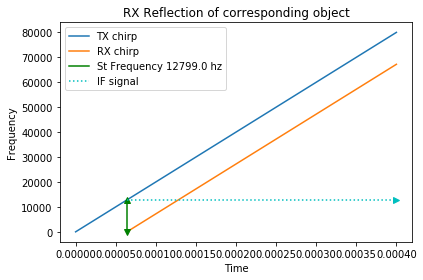

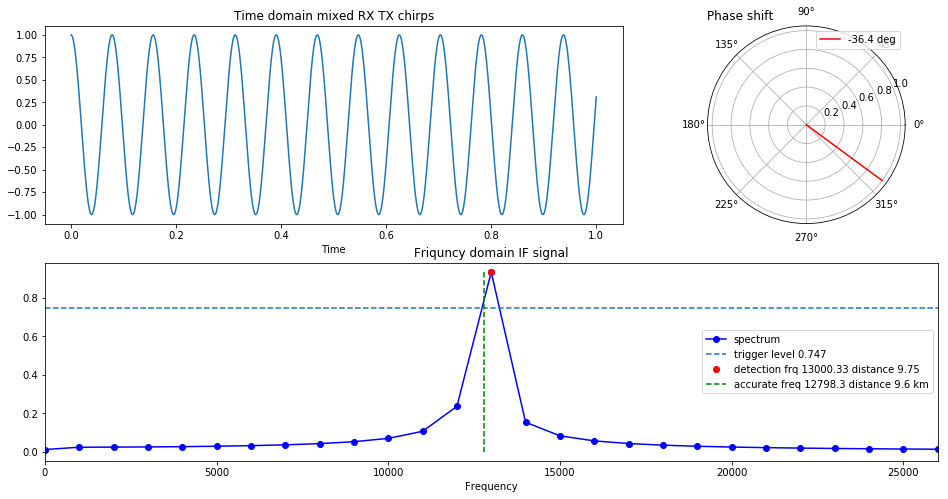

In [5]:
chirp = chirp_gen(duration,npnts,start_freq, band_freq)
print('Theoretical max distance of a chirp of', light_speed_km * duration / 2, 'km')
smallest_measure_distance = light_speed_km * (1 / samples_one_second) / 2
print('smallest measure distance',smallest_measure_distance, 'km')

shift = int((1 / smallest_measure_distance) * kilometer)
print('shift', shift, 'out of', npnts, 'sample points, for a distance of', np.round(shift * smallest_measure_distance, 2), 'km')
distance_per_herz = (light_speed_km * duration / 2) / band_freq
print('Friquncy domain per distance', distance_per_herz, 'km per herz')
print()

chirp_time = np.linspace(0, duration, npnts)
chirp_freq = np.linspace(0, band_freq, npnts)
plt.plot(chirp_time, chirp_freq, label='TX chirp')
plt.plot(chirp_time[shift:], chirp_freq[:-shift], label='RX chirp')
plt.plot([chirp_time[shift],chirp_time[shift]], [0,chirp_freq[shift]], 'g-' , label='St Frequency {} hz'.format(np.round(chirp_freq[shift])))
plt.plot(chirp_time[shift],0, 'gv')
plt.plot(chirp_time[shift],chirp_freq[shift], 'g^')

plt.plot([chirp_time[shift],chirp_time[-1]],[chirp_freq[shift],chirp_freq[shift]], 'c:', label='IF signal')
plt.plot([chirp_time[-1]],[chirp_freq[shift]], 'c>')

plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('RX Reflection of corresponding object')

plt.legend()
plt.tight_layout()
plt.show()

one_object_detector()